In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 ***
<a id='lesson-4'></a>
# Lesson-4: Molecular Dynamics
***
- Molecular Dynamics is essentially the application of the Newtons Second Law to molecules, where the force acting on each part of the molecule is computed by modelling its interaction with every other part of the system.
- Total potential energy of the system: 
$$ U = \sum_{i\in\{bonds\}} \frac{1}{2} k_{b,i} (d_i - d_{0,i})^2 + \sum_{i\in\{angles\}} \frac{1}{2} k_{a,i} (\theta_i - \theta_{0,i})^2 + \\ \sum_{i\in\{dihedrals\}} \phi ( cos(n\theta_i)-1)  +  \sum_{i,j\in\{non-bond~pairs\}} \left( U_{LJ}(i,j) +  U_{Columbic}(i,j)\right)
$$
- Equations of motion given by:
$$ \frac{d\vec{p}_i}{dt} = \vec{F}_i \\ \frac{d \vec{r}_i}{dt} = \vec{p}_i/m_i $$
- Euler Method:
$$ \vec{p}_i(t+dt) = \vec{p}_i(t) + dt~\vec{F}_i(t) \\ \vec{r}_i(t+dt)=\vec{r}_i(t) + dt\vec{p}_i/m_i
$$
where the atom index $i \in [1,N]$
- Check on accuracy: constant total energy, total linear momentum
- Example: Simple harmonic oscillator

## Example: Argon
Argon atom is electrically neutral and a good model for the pair-wise interaction between two Argon atoms is given by Lennard-Jones potential, whose functional form is given by:
$$ U_{LJ} (\vec{r}_i,\vec{r}_j) = 4 \epsilon \left( \left(\frac{\sigma}{r} \right)^{12}- \left(\frac{\sigma}{r} \right)^6 \right)  $$
where $\vec{r} = \vec{r}_i - \vec{r}_j$ and $r=|\vec{r}|$. The force on particle $i$ due to its interaction via LJ potenital with particle $j$ is then given by: $$-\left( \frac{\partial U_{LJ}}{\partial x_i}, \frac{\partial U_{LJ}}{\partial y_i},\frac{\partial U_{LJ}}{\partial z_i} \right)$$
And the total potential of the system of $N$ Argon atoms is sum of all the pairwise interactions, i.e.,
$$ U = \frac{1}{2} \sum_{i,j=1, i\ne j}^N U_{LJ} (\vec{r}_i,\vec{r}_j) $$
Using the Euler method mentioned above, write a program to compute the trajectory of the system! 

Following functions might need to be written:

- `initialise_config`
- `initialise_momenta`
- `compute_force`, `compute_pairwiseLJ(i, j, sigma, epsilon)`
- `compute_totalEnergy`, `compute_energy_pairwiseLJ(i, j, sigma, epsilon)`
- `euler_integrate(timestep)`



In [2]:
# set some basic stuff of the simulation
numParticles = 64
dim = 2   # dimensionlaity of system, 2 for ease of visualisation
kBT = 1.0 # temperature
mass = 40 * 1.6 * (10**-27)  # mass of argon gas
# mass = 40

# set interaction parameters: sigma and epsilon 
sigma = 1.0 
epsilon = 1.0

# set integrator parameters
dt = 0.01

# setup arrays for storing stuff
positons = numpy.zeros( (numParticles, dim) )
momentas = numpy.zeros( (numParticles, dim) )
forces   = numpy.zeros( (numParticles, dim) )

In [3]:
# initialise_config
def initialize_positions( boxLength_in ):
    global positions, numParticles, dim, boxLength
    boxLength = boxLength_in
    # set positions: lattice start inside a box of length 'boxLength'
    positions = np.random.uniform(0,boxLength,(numParticles,dim))
    
    return

In [4]:

# initialization of momentas
def initialize_momentas(temp):
    global positions, momentas, forces, numParticles, dim, kBT, mass
    # set momenta, as Maxwell-Boltzmann distribution at temperaute 'temp'
    kBT = temp    
    momentas = np.random.normal(0, sqrt(2*mass*1.38*(10**-23)*kBT), (numParticles,dim))

    return

In [5]:
# # funciton to compute forces on all particles in system
# def calc_forces():
#     global numParticles, sigma, epsilon, dim
    
#     forces   = numpy.zeros( (numParticles, dim) )
#     for i in range(numParticles):
#         for j in range(numParticles):
#             forces[i] += compute_pairwiseLJ(i, j, sigma, epsilon)
#        # j = linspace(1, numParticles, numParticles)
#     # forces[i] += compute_pairwiseLJ(i, j, sigma, epsilon)
            
            
            
#     return

# # function to compute pairwise forces
# def compute_pairwiseLJ(i,j,sigma,epsilon):
#     global positons
#     if (i==j):
#         return 0
    
#     r = np.linalg.norm(np.subtract(positions[i], positions[j]))
#     Force = 24*( ((sigma/r)**12) - ((sigma/r)**6) )/(r*r)
#     Force_vec = Force*np.subtract(positions[i],positions[j])[:]
#     return Force_vec

In [6]:
def calc_forces():
    global positions, sigma, epsilon, forces
    for idx, vec in enumerate(positions):
        r = np.linalg.norm(vec - positions, axis = 1)
        r = np.delete(r, idx)
        position_temp = np.delete(vec - positions, idx, 0)
        force_mag = 24*epsilon*( 2*((sigma/r)**12) - ((sigma/r)**6) )/(r*r)
        forces[idx]= np.sum(position_temp*force_mag [:, None], axis = 0)
    return 

In [7]:
# # function to compute total Energy of system
# def compute_totalEnergy():
#     global positions, momentas, mass, numParticles, sigma, epsilon
#     # calculate kinetic energy from momenta
#     KE = np.sum(momentas[:]*momentas[:])/mass
#     # calculate potential energy  using calc_energy_pairwiseLJ(i,j,sigma,epsilon)
#     PE = 0
#     for i in range(numParticles):
#         for j in range(numParticles):
#             PE += calc_energy_pairwiseLJ(i, j, sigma, epsilon)

#     return (KE+PE)

# def calc_energy_pairwiseLJ(i,j,sigma,epsilon):
#     global positions
#     if i==j:
#         return 0
    
#     r = np.linalg.norm(np.subtract(positions[i], positions[j]))
#     Energy = 4*( ((sigma/r)**12) - ((sigma/r)**6) )
#     return Energy

In [8]:
def potential_curve():
    global positions, sigma, epsilon, mass, momentas
    Pot_Energy = 0
    for idx, vec in enumerate(positions):
        r = np.linalg.norm(vec-positions, axis = 1)
        r = np.delete(r, idx)
        Pot_Energy += 4*epsilon*( ((sigma/r)**12) - ((sigma/r)**6) )
    Pot_Energy = np.sum(Pot_Energy)
    
    Kin_Ener = np.sum(einsum('ij,ij->i', momentas, momentas))/(2*mass)
    
    Energy = Pot_Energy + Kin_Ener
    
    return Pot_Energy, Kin_Ener, Energy

In [9]:
# integrator
def euler_integrate(dt):
    global positions, momentas, forces, boxLength, mass
    calc_forces()
    positions += dt * (momentas / mass)
    # positions = np.mod(positions, boxLength)
    momentas += dt * forces
    return

In [10]:
def configDraw():
    global positions
    figure(figsize=(8,8)) # setup figure of 8 inches x 8 inches
    axis = gca()         # get current axes
    axis.set_xlim(0,(30))  # xlim (-15,15)
    axis.set_ylim(0,(30))  # ylim (-15,15)
    circles = []
    for i in range(numParticles):
        circles.append( axis.add_patch( Circle( positions[i], radius=0.5,
                                                linewidth=2, edgecolor='black') ) )
    grid()
    show()
    
    return

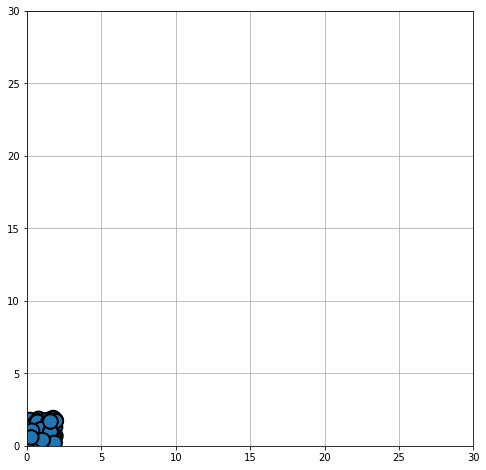

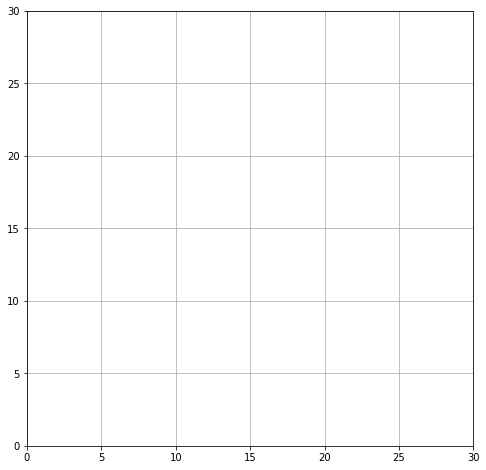

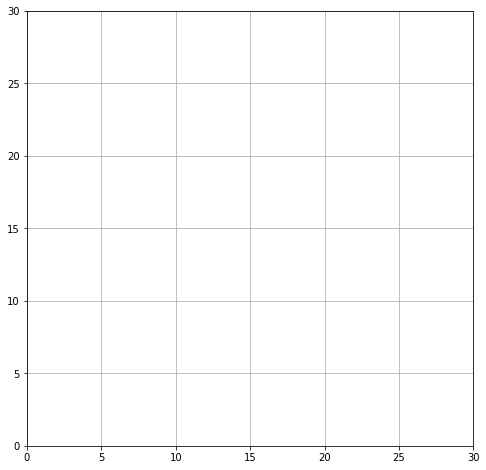

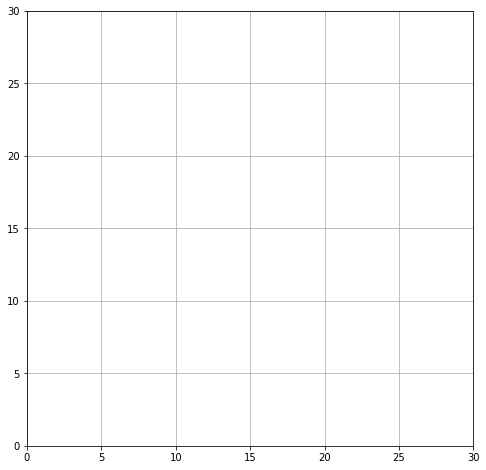

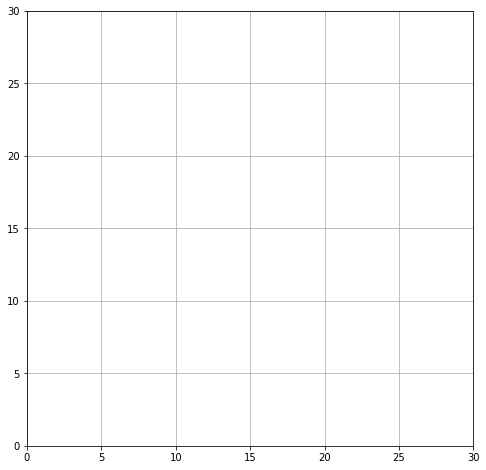

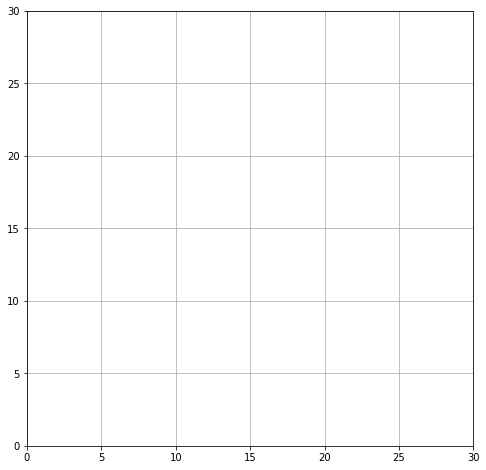

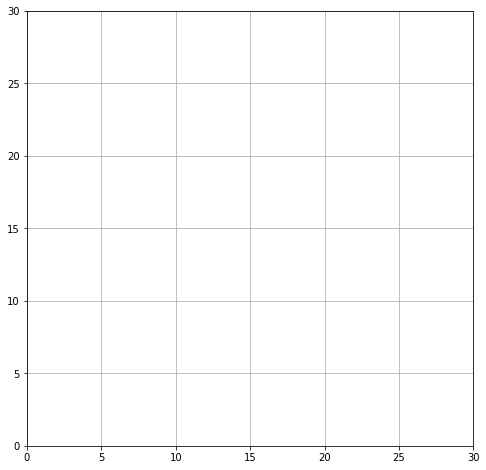

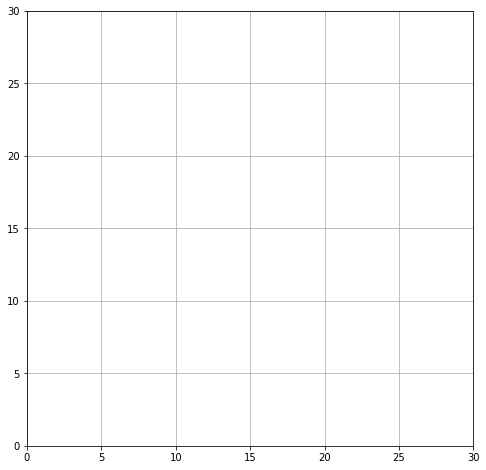

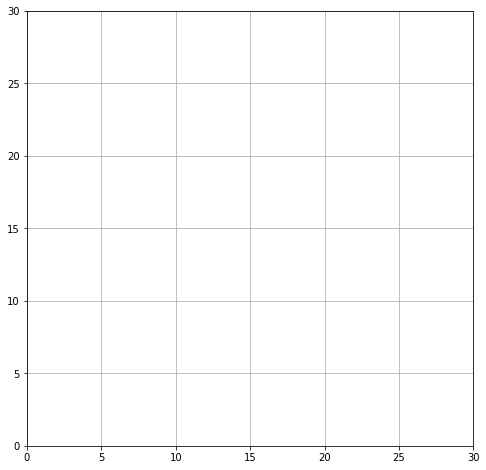

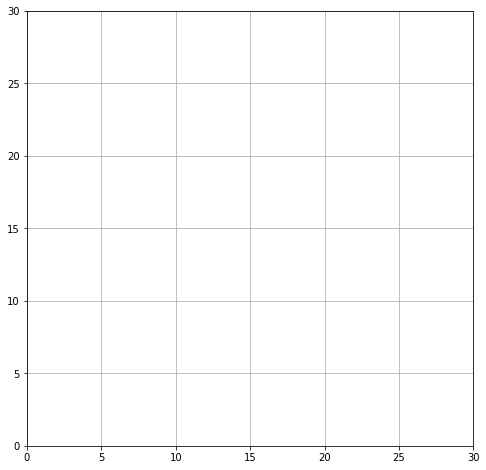

In [11]:
#### 
initialize_positions(2)
initialize_momentas(273)
dt = 1/np.power(10, 9)
tot_steps = 1000
Energy_plot = []
Kinetic = []
Tot = []
for steps in range(tot_steps):
    euler_integrate(dt)
    Energy_plot.append(potential_curve()[0])
    Kinetic.append(potential_curve()[1])
    Tot.append(potential_curve()[2])
    if (steps % 100==0):
        configDraw()

In [1]:
# plot(Energy_plot, label="potential")
plot(Kinetic, label="kinetic")
plot(Tot, label="Total")
legend()

NameError: name 'plot' is not defined